# Yield Optimization - Solution ESG pour ClientCo

**Objectif** : Utiliser l'IA pour optimiser les achats de céréales et réduire l'impact environnemental tout en améliorant la résilience agricole.

**Problème business et ESG** :
- Rendement instable à cause de sécheresses, manque de précipitations, vagues de chaleur
- Conséquences ESG : plus d'irrigation → plus d'eau, pertes de récolte → gaspillage, sourcing d'urgence → transport → Scope 3 élevé
- **Solution** : Acheter dans les zones où le rendement sera stable et résilient


In [24]:
# Import des bibliothèques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Chargement des données
raw_data_path = Path("Raw data")
barley_df = pd.read_csv(raw_data_path / "barley_yield_from_1982.csv", sep=';')
climate_df = pd.read_parquet(raw_data_path / "climate_data_from_1982.parquet")

# Nettoyage
barley_df = barley_df.drop(columns=['Unnamed: 0'], errors='ignore')

print("✅ Données chargées!")
print(f"Barley: {barley_df.shape}")
print(f"Climate: {climate_df.shape}")


✅ Données chargées!
Barley: (3583, 5)
Climate: (13540116, 7)


## ÉTAPE 1 : Comprendre les risques climat + yield (Analyse descriptive)


In [25]:
# Préparation des données climatiques
precip_data = climate_df[climate_df['metric'] == 'precipitation']
precip_data = precip_data[precip_data['scenario'] == 'historical']

temp_data = climate_df[climate_df['metric'] == 'near_surface_air_temperature']
temp_data = temp_data[temp_data['scenario'] == 'historical']
temp_data['temp_celsius'] = temp_data['value'] - 273.15

# Agrégation par département (sans std précipitations)
precip_by_dept = precip_data.groupby('nom_dep')['value'].mean().reset_index()
precip_by_dept.columns = ['department', 'precip_mean']

temp_by_dept = temp_data.groupby('nom_dep')['temp_celsius'].agg(['mean', 'max']).reset_index()
temp_by_dept.columns = ['department', 'temp_mean', 'temp_max']

# Données de yield
yield_by_dept = barley_df.groupby('department').agg({
    'yield': 'mean',
    'production': 'mean'
}).reset_index()
yield_by_dept.columns = ['department', 'yield_mean', 'production_mean']

# Fusion des données
risk_analysis = yield_by_dept.merge(precip_by_dept, on='department', how='inner')
risk_analysis = risk_analysis.merge(temp_by_dept, on='department', how='inner')

print(f"Données préparées pour {len(risk_analysis)} départements")
print("\nColonnes disponibles:", risk_analysis.columns.tolist())


Données préparées pour 89 départements

Colonnes disponibles: ['department', 'yield_mean', 'production_mean', 'precip_mean', 'temp_mean', 'temp_max']


In [26]:
# Identification des départements à risque climatique
# Critères CLIMATIQUES uniquement : peu de précipitations + température élevée + faible yield

risk_analysis['precip_low'] = risk_analysis['precip_mean'] < risk_analysis['precip_mean'].quantile(0.33)
risk_analysis['temp_high'] = risk_analysis['temp_mean'] > risk_analysis['temp_mean'].quantile(0.67)
risk_analysis['temp_max_high'] = risk_analysis['temp_max'] > risk_analysis['temp_max'].quantile(0.67)
risk_analysis['yield_low'] = risk_analysis['yield_mean'] < risk_analysis['yield_mean'].quantile(0.33)

# Score de risque CLIMATIQUE (sans area - area sert juste à prioriser l'impact)
risk_analysis['risk_score'] = (
    (risk_analysis['precip_low'].astype(int) * 0.35) +      # Peu de précipitations
    (risk_analysis['temp_high'].astype(int) * 0.25) +       # Température élevée
    (risk_analysis['temp_max_high'].astype(int) * 0.15) +   # Températures maximales élevées
    (risk_analysis['yield_low'].astype(int) * 0.25)         # Faible yield (conséquence)
)

# Score de PRIORITÉ (pour savoir où agir) = Risque × Production (impact économique)
risk_analysis['production_norm'] = (risk_analysis['production_mean'] - risk_analysis['production_mean'].min()) / (risk_analysis['production_mean'].max() - risk_analysis['production_mean'].min())
risk_analysis['priority_score'] = risk_analysis['risk_score'] * risk_analysis['production_norm']

# Départements à risque élevé
high_risk_depts = risk_analysis[risk_analysis['risk_score'] >= 0.4].sort_values('risk_score', ascending=False)

print("=== DÉPARTEMENTS À RISQUE CLIMATIQUE ===")
print("Score de risque = Précipitations (35%) + Température (40%) + Yield (25%)")
print("(Area utilisé uniquement pour prioriser l'impact, pas pour le risque)\n")
print(f"Nombre de départements à risque élevé: {len(high_risk_depts)}")
print("\nTop 15 départements à risque:")
print(high_risk_depts[['department', 'precip_mean', 'temp_mean', 'temp_max', 'yield_mean', 'risk_score', 'priority_score']].round(3))


=== DÉPARTEMENTS À RISQUE CLIMATIQUE ===
Score de risque = Précipitations (35%) + Température (40%) + Yield (25%)
(Area utilisé uniquement pour prioriser l'impact, pas pour le risque)

Nombre de départements à risque élevé: 34

Top 15 départements à risque:
             department  precip_mean  temp_mean   temp_max  yield_mean  \
80      Tarn_et_Garonne          0.0     11.933  31.393000       4.472   
12     Bouches_du_Rhone          0.0     13.473  30.806999       3.270   
34        Haute_Garonne          0.0     11.606  30.201000       4.648   
83             Vaucluse          0.0     11.479  28.802999       3.672   
71  Pyrenees_Orientales          0.0     11.883  27.659000       2.300   
53                  Lot          0.0     10.912  29.459000       4.193   
26              Essonne          0.0     10.851  31.045000       6.378   
54       Lot_et_Garonne          0.0     12.641  31.346001       4.841   
15             Charente          0.0     11.677  30.167000       5.000   
45

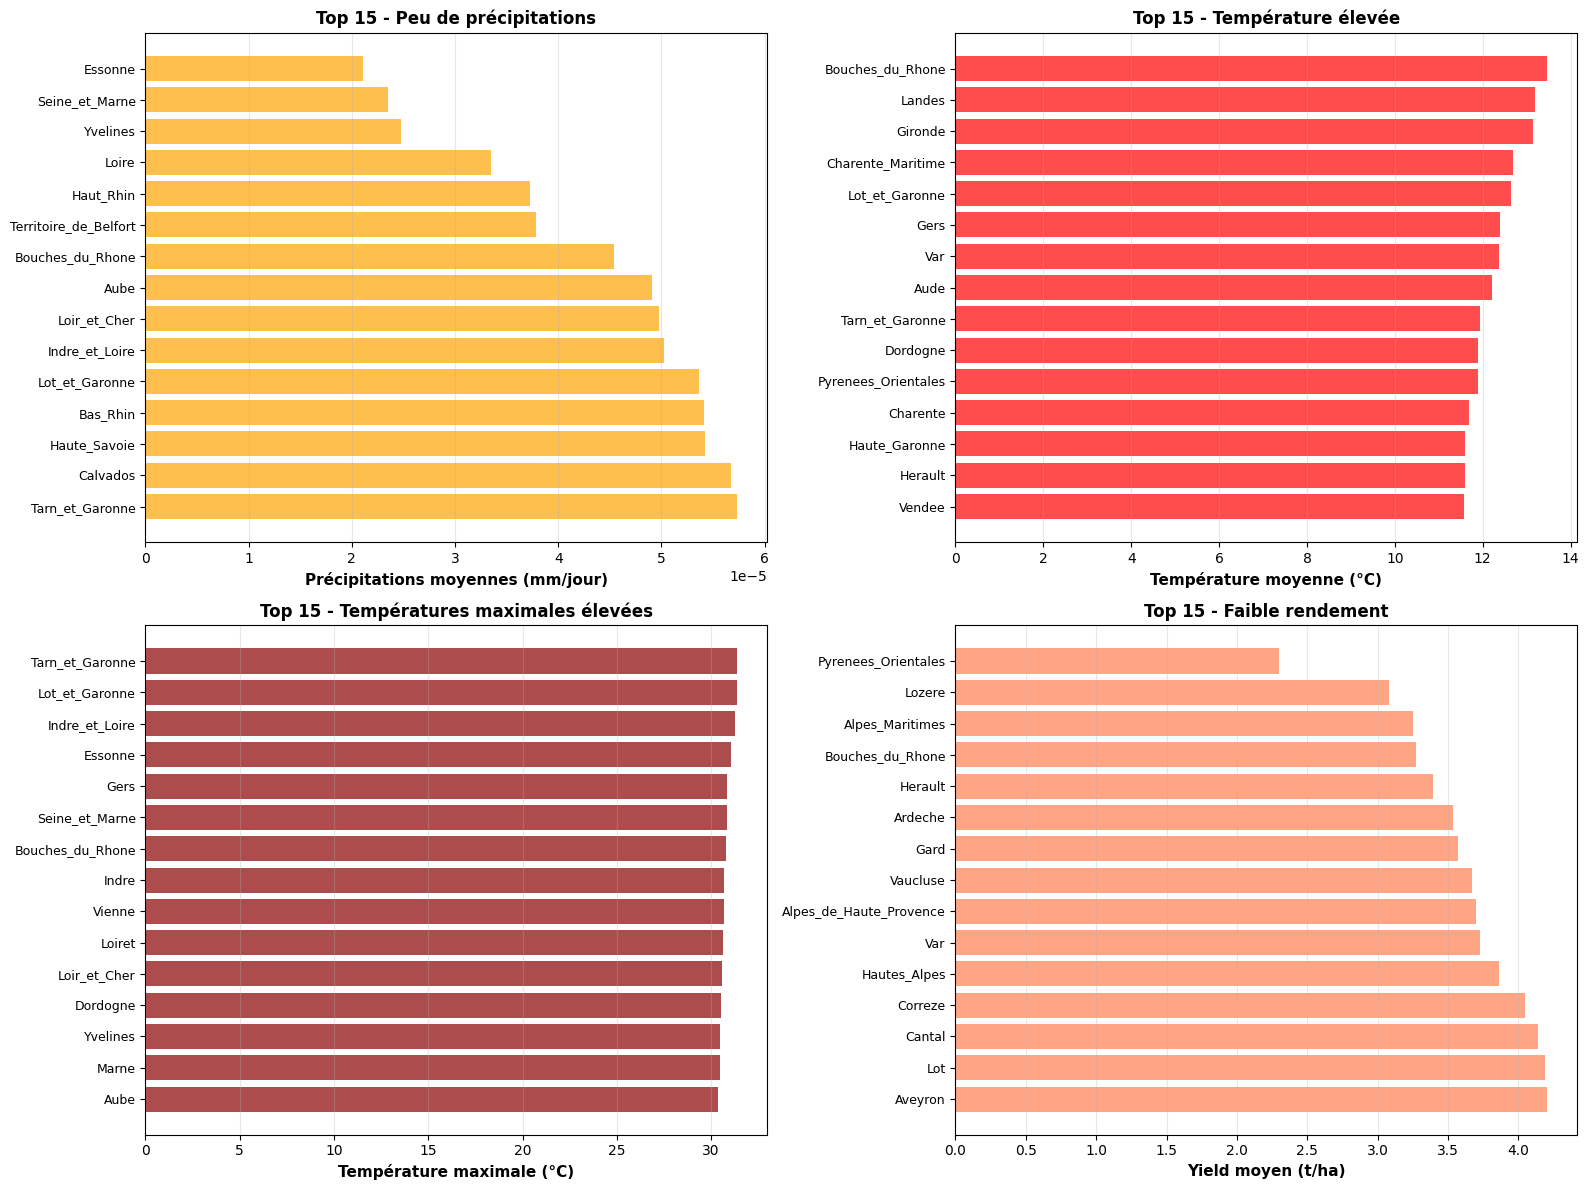


💡 Analyse ESG n°1 : Ces départements fragilisent les achats de ClientCo
   → Peu d'eau + Température élevée + Faible yield = risque climatique élevé
   → Area/production utilisée uniquement pour PRIORISER où agir (impact économique)


In [27]:
# Visualisation des zones à risque
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Précipitations moyennes (faibles)
top_low_precip = risk_analysis.nsmallest(15, 'precip_mean')
axes[0, 0].barh(range(len(top_low_precip)), top_low_precip['precip_mean'], color='orange', alpha=0.7)
axes[0, 0].set_yticks(range(len(top_low_precip)))
axes[0, 0].set_yticklabels(top_low_precip['department'], fontsize=9)
axes[0, 0].set_xlabel('Précipitations moyennes (mm/jour)', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Top 15 - Peu de précipitations', fontsize=12, fontweight='bold')
axes[0, 0].invert_yaxis()
axes[0, 0].grid(True, alpha=0.3, axis='x')

# 2. Température moyenne (élevée)
top_high_temp = risk_analysis.nlargest(15, 'temp_mean')
axes[0, 1].barh(range(len(top_high_temp)), top_high_temp['temp_mean'], color='red', alpha=0.7)
axes[0, 1].set_yticks(range(len(top_high_temp)))
axes[0, 1].set_yticklabels(top_high_temp['department'], fontsize=9)
axes[0, 1].set_xlabel('Température moyenne (°C)', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Top 15 - Température élevée', fontsize=12, fontweight='bold')
axes[0, 1].invert_yaxis()
axes[0, 1].grid(True, alpha=0.3, axis='x')

# 3. Température maximale (vagues de chaleur)
top_high_temp_max = risk_analysis.nlargest(15, 'temp_max')
axes[1, 0].barh(range(len(top_high_temp_max)), top_high_temp_max['temp_max'], color='darkred', alpha=0.7)
axes[1, 0].set_yticks(range(len(top_high_temp_max)))
axes[1, 0].set_yticklabels(top_high_temp_max['department'], fontsize=9)
axes[1, 0].set_xlabel('Température maximale (°C)', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Top 15 - Températures maximales élevées', fontsize=12, fontweight='bold')
axes[1, 0].invert_yaxis()
axes[1, 0].grid(True, alpha=0.3, axis='x')

# 4. Yield faible
top_low_yield = risk_analysis.nsmallest(15, 'yield_mean')
axes[1, 1].barh(range(len(top_low_yield)), top_low_yield['yield_mean'], color='coral', alpha=0.7)
axes[1, 1].set_yticks(range(len(top_low_yield)))
axes[1, 1].set_yticklabels(top_low_yield['department'], fontsize=9)
axes[1, 1].set_xlabel('Yield moyen (t/ha)', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Top 15 - Faible rendement', fontsize=12, fontweight='bold')
axes[1, 1].invert_yaxis()
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("\n💡 Analyse ESG n°1 : Ces départements fragilisent les achats de ClientCo")
print("   → Peu d'eau + Température élevée + Faible yield = risque climatique élevé")
print("   → Area/production utilisée uniquement pour PRIORISER où agir (impact économique)")


## ÉTAPE 2 : Lier Climat → Yield (Modèle prédictif)


In [28]:
# Feature Engineering : Création d'indicateurs climatiques annuels
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

# Préparation des données annuelles par département
ml_data = []

for dept in barley_df['department'].unique():
    dept_barley = barley_df[barley_df['department'] == dept].copy()
    
    for _, row in dept_barley.iterrows():
        year = row['year']
        dept_name = row['department']
        
        # Données climatiques pour cette année
        temp_year = temp_data[(temp_data['nom_dep'] == dept_name) & (temp_data['year'] == year)]
        precip_year = precip_data[(precip_data['nom_dep'] == dept_name) & (precip_data['year'] == year)]
        
        if len(temp_year) > 0 and len(precip_year) > 0:
            # Features climatiques annuelles (avec température importante)
            features = {
                'department': dept_name,
                'year': year,
                'precip_total': precip_year['value'].sum(),  # Cumul annuel
                'precip_mean': precip_year['value'].mean(),
                'precip_max': precip_year['value'].max(),
                'precip_min': precip_year['value'].min(),
                'days_dry': len(precip_year[precip_year['value'] < 0.0001]),  # Jours secs (< 1mm)
                'temp_mean': temp_year['temp_celsius'].mean(),
                'temp_max': temp_year['temp_celsius'].max(),
                'temp_min': temp_year['temp_celsius'].min(),
                'temp_range': temp_year['temp_celsius'].max() - temp_year['temp_celsius'].min(),
                'days_hot': len(temp_year[temp_year['temp_celsius'] > 20]),  # Jours chauds (>20°C)
                'days_very_hot': len(temp_year[temp_year['temp_celsius'] > 25]),  # Jours très chauds (>25°C)
                'yield': row['yield']
            }
            ml_data.append(features)

ml_df = pd.DataFrame(ml_data).dropna()

print(f"Dataset ML créé: {len(ml_df)} observations")
print(f"Période: {ml_df['year'].min()} - {ml_df['year'].max()}")
print(f"\nAperçu des features:")
print(ml_df.head())


Dataset ML créé: 2835 observations
Période: 1982 - 2014

Aperçu des features:
  department  year  precip_total  precip_mean  precip_max    precip_min  \
0        Ain  1982      0.027494     0.000075    0.000870  9.783581e-12   
2        Ain  1984      0.027781     0.000076    0.000987  3.023963e-11   
3        Ain  1985      0.034206     0.000094    0.000887  5.795747e-12   
4        Ain  1986      0.023955     0.000066    0.000724  2.607235e-11   
5        Ain  1987      0.035535     0.000097    0.001018  1.119111e-10   

   days_dry  temp_mean   temp_max   temp_min  temp_range  days_hot  \
0       273   9.629249  25.357819  -7.825348   33.183167        28   
2       265   8.904198  22.934387 -10.333954   33.268341        19   
3       251   8.529643  21.471191  -8.281158   29.752350        11   
4       290   9.271490  23.056061  -3.856720   26.912781        26   
5       245   8.687550  22.628906  -9.685303   32.314209        15   

   days_very_hot    yield  
0              1  3.95

In [29]:
# Features pour le modèle
feature_cols = ['precip_total', 'precip_mean', 'precip_max', 'precip_min', 'days_dry',
                'temp_mean', 'temp_max', 'temp_min', 'temp_range', 'days_hot', 'days_very_hot']

X = ml_df[feature_cols]
y = ml_df['yield']

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entraînement Random Forest
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Prédictions et métriques
y_pred_train = rf_model.predict(X_train)
y_pred_test = rf_model.predict(X_test)

mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print("=== PERFORMANCE DU MODÈLE PRÉDICTIF ===")
print(f"\n📊 Métriques de test:")
print(f"   MAE: {mae_test:.3f} t/ha")
print(f"   R²: {r2_test:.3f}")
print(f"   → Le modèle explique {r2_test*100:.1f}% de la variance du yield\n")

# Importance des features
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("🔍 Variables les plus importantes:")
print(feature_importance)


=== PERFORMANCE DU MODÈLE PRÉDICTIF ===

📊 Métriques de test:
   MAE: 0.771 t/ha
   R²: 0.462
   → Le modèle explique 46.2% de la variance du yield

🔍 Variables les plus importantes:
          feature  importance
3      precip_min    0.199241
6        temp_max    0.191118
5       temp_mean    0.128224
2      precip_max    0.120108
4        days_dry    0.096759
7        temp_min    0.073315
9        days_hot    0.060857
8      temp_range    0.059591
1     precip_mean    0.027665
0    precip_total    0.025029
10  days_very_hot    0.018093


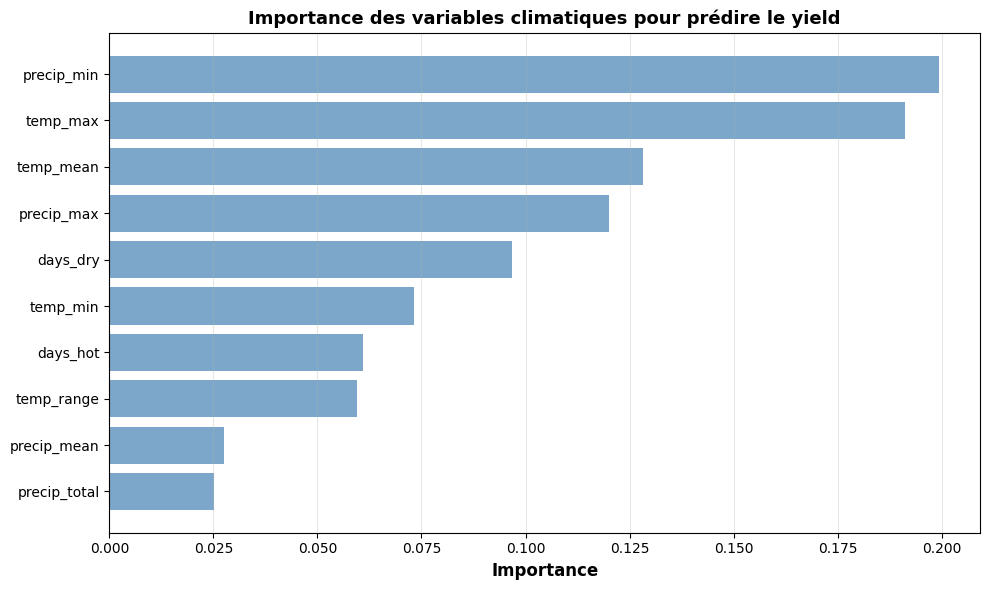


💡 Analyse ESG n°2 : Le yield dépend fortement du climat → risque pour ClientCo
   → 46.2% de la variance expliquée par les variables climatiques
   → Variables clés: precip_min, temp_max, temp_mean


In [30]:
# Visualisation de l'importance des features
fig, ax = plt.subplots(figsize=(10, 6))
top_features = feature_importance.head(10)
ax.barh(range(len(top_features)), top_features['importance'], color='steelblue', alpha=0.7)
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['feature'], fontsize=10)
ax.set_xlabel('Importance', fontsize=12, fontweight='bold')
ax.set_title('Importance des variables climatiques pour prédire le yield', fontsize=13, fontweight='bold')
ax.invert_yaxis()
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("\n💡 Analyse ESG n°2 : Le yield dépend fortement du climat → risque pour ClientCo")
print(f"   → {r2_test*100:.1f}% de la variance expliquée par les variables climatiques")
print(f"   → Variables clés: {', '.join(top_features.head(3)['feature'].tolist())}")


## ÉTAPE 3 : Prédire les départements les plus résilients


In [31]:
# Prédictions pour les dernières années (2010-2018) par département
recent_data = ml_df[ml_df['year'] >= 2010].copy()

# Prédictions de yield
recent_data['yield_predicted'] = rf_model.predict(recent_data[feature_cols])

# Calcul de la résilience par département (avec température)
resilience_metrics = recent_data.groupby('department').agg({
    'yield_predicted': ['mean', 'std'],
    'precip_mean': 'mean',
    'days_dry': 'mean',
    'temp_mean': 'mean',
    'temp_max': 'mean',
    'days_hot': 'mean',
    'days_very_hot': 'mean'
}).reset_index()

resilience_metrics.columns = ['department', 'yield_mean', 'yield_volatility', 
                               'precip_mean', 'days_dry_mean', 
                               'temp_mean', 'temp_max_mean', 'days_hot_mean', 'days_very_hot_mean']

# Normalisation pour le score de résilience
resilience_metrics['yield_mean_norm'] = (resilience_metrics['yield_mean'] - resilience_metrics['yield_mean'].min()) / (resilience_metrics['yield_mean'].max() - resilience_metrics['yield_mean'].min())
resilience_metrics['yield_volatility_norm'] = 1 - (resilience_metrics['yield_volatility'] - resilience_metrics['yield_volatility'].min()) / (resilience_metrics['yield_volatility'].max() - resilience_metrics['yield_volatility'].min())
resilience_metrics['stress_hydrique'] = (resilience_metrics['days_dry_mean'] - resilience_metrics['days_dry_mean'].min()) / (resilience_metrics['days_dry_mean'].max() - resilience_metrics['days_dry_mean'].min())
resilience_metrics['stress_thermique'] = (resilience_metrics['days_very_hot_mean'] - resilience_metrics['days_very_hot_mean'].min()) / (resilience_metrics['days_very_hot_mean'].max() - resilience_metrics['days_very_hot_mean'].min())

# Score de résilience (avec température)
resilience_metrics['resilience_score'] = (
    resilience_metrics['yield_mean_norm'] * 0.35 +
    resilience_metrics['yield_volatility_norm'] * 0.25 +
    (1 - resilience_metrics['stress_hydrique']) * 0.25 +
    (1 - resilience_metrics['stress_thermique']) * 0.15
)

print("=== SCORE DE RÉSILIENCE PAR DÉPARTEMENT ===")
print(f"\nScore = +yield moyen - volatilité yield - stress hydrique - stress thermique")
print(f"\nTop 15 départements les plus résilients:")
top_resilient = resilience_metrics.nlargest(15, 'resilience_score')
print(top_resilient[['department', 'yield_mean', 'yield_volatility', 'days_dry_mean', 'days_very_hot_mean', 'resilience_score']].round(3))


=== SCORE DE RÉSILIENCE PAR DÉPARTEMENT ===

Score = +yield moyen - volatilité yield - stress hydrique - stress thermique

Top 15 départements les plus résilients:
         department  yield_mean  yield_volatility  days_dry_mean  \
67             Orne       6.114             0.183         245.20   
64           Nievre       5.948             0.073         263.20   
57           Manche       5.945             0.164         252.80   
75           Savoie       5.087             0.220         197.00   
21           Creuse       5.463             0.150         236.00   
76   Seine_Maritime       6.549             0.323         260.00   
46            Isere       4.923             0.079         231.25   
27             Eure       6.478             0.266         269.60   
61            Meuse       6.032             0.257         247.00   
24            Doubs       5.177             0.124         241.20   
66             Oise       6.488             0.351         245.80   
36      Haute_Marne 

In [32]:
# Classification en 3 zones : Vert (résilient), Orange (moyen), Rouge (à risque)
resilience_metrics['zone'] = pd.cut(
    resilience_metrics['resilience_score'],
    bins=[0, 0.4, 0.6, 1.0],
    labels=['Rouge', 'Orange', 'Vert']
)

zone_counts = resilience_metrics['zone'].value_counts()
print("=== CLASSIFICATION DES DÉPARTEMENTS ===")
print(f"\n🟢 Zones VERTES (résilientes - à privilégier): {zone_counts.get('Vert', 0)} départements")
print(f"🟠 Zones ORANGES (moyennes - à surveiller): {zone_counts.get('Orange', 0)} départements")
print(f"🔴 Zones ROUGES (à risque - à réduire): {zone_counts.get('Rouge', 0)} départements\n")

print("Départements par zone:")
for zone in ['Vert', 'Orange', 'Rouge']:
    depts = resilience_metrics[resilience_metrics['zone'] == zone]['department'].tolist()
    print(f"\n{zone}: {', '.join(depts[:10])}{'...' if len(depts) > 10 else ''}")


=== CLASSIFICATION DES DÉPARTEMENTS ===

🟢 Zones VERTES (résilientes - à privilégier): 62 départements
🟠 Zones ORANGES (moyennes - à surveiller): 24 départements
🔴 Zones ROUGES (à risque - à réduire): 3 départements

Départements par zone:

Vert: Ain, Aisne, Allier, Ardennes, Ariege, Aube, Aveyron, Bas_Rhin, Calvados, Cantal...

Orange: Alpes_Maritimes, Alpes_de_Haute_Provence, Ardeche, Aude, Charente, Charente_Maritime, Dordogne, Essonne, Gard, Gers...

Rouge: Bouches_du_Rhone, Lot_et_Garonne, Pyrenees_Orientales


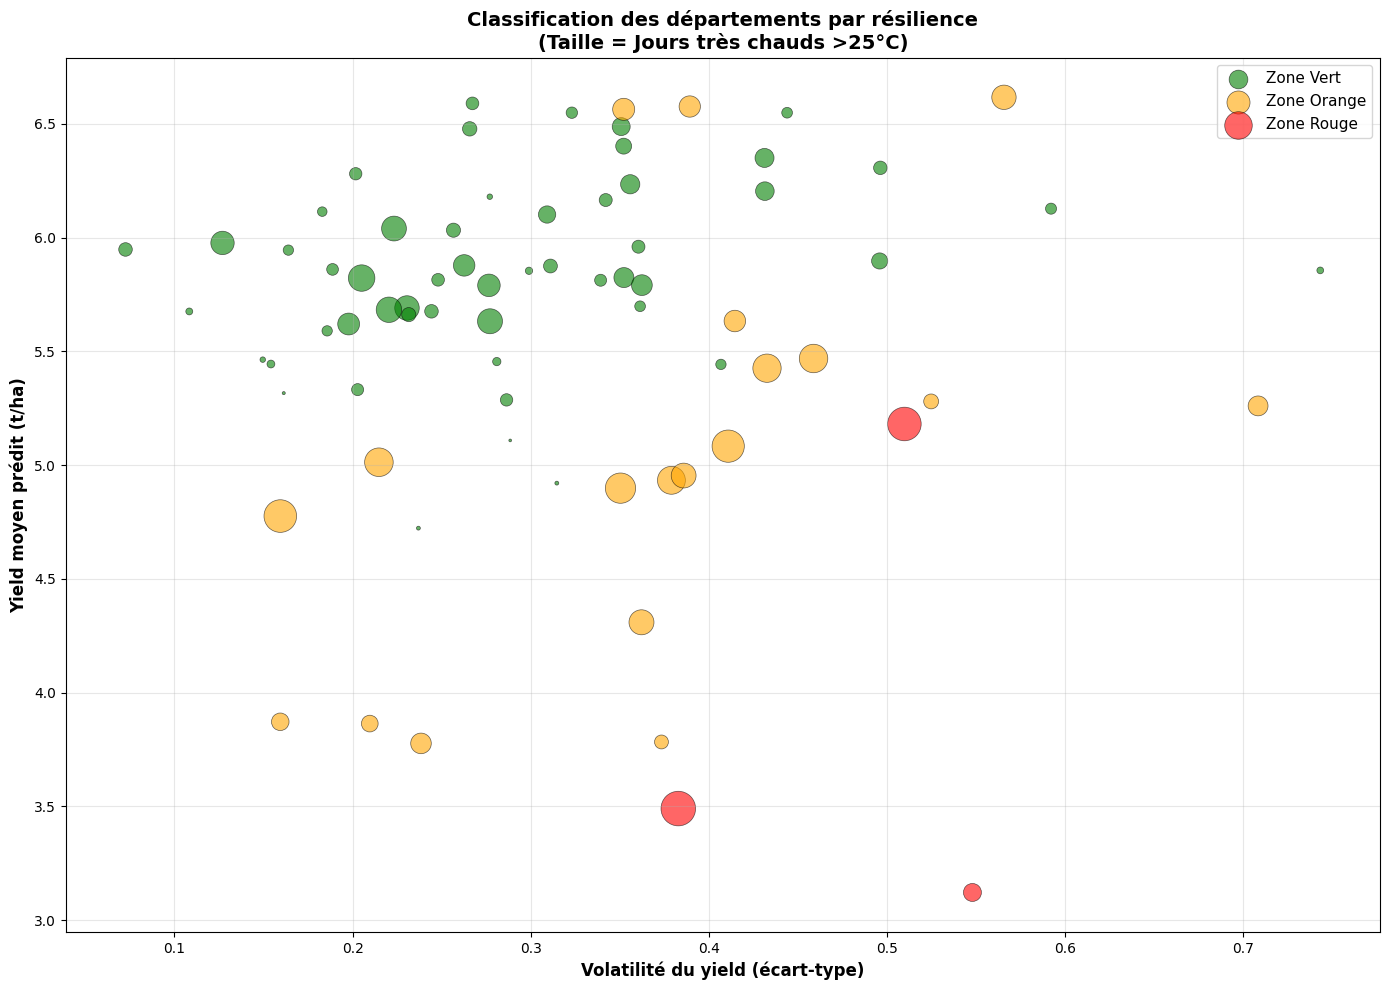


💡 Résultat clé : On sait où ClientCo doit acheter en priorité pour réduire l'impact ESG


In [33]:
# Visualisation de la classification
fig, ax = plt.subplots(figsize=(14, 10))

# Scatter plot avec couleurs par zone (taille = jours très chauds)
zones_colors = {'Vert': 'green', 'Orange': 'orange', 'Rouge': 'red'}
for zone in ['Vert', 'Orange', 'Rouge']:
    zone_data = resilience_metrics[resilience_metrics['zone'] == zone]
    ax.scatter(zone_data['yield_volatility'], zone_data['yield_mean'],
              s=zone_data['days_very_hot_mean']*20, alpha=0.6,
              c=zones_colors[zone], label=f'Zone {zone}', edgecolors='black', linewidth=0.5)

ax.set_xlabel('Volatilité du yield (écart-type)', fontsize=12, fontweight='bold')
ax.set_ylabel('Yield moyen prédit (t/ha)', fontsize=12, fontweight='bold')
ax.set_title('Classification des départements par résilience\n(Taille = Jours très chauds >25°C)', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n💡 Résultat clé : On sait où ClientCo doit acheter en priorité pour réduire l'impact ESG")


## ÉTAPE 4 : Optimiser les achats (Yield Optimization)


In [34]:
# Fusion avec les données de production pour l'optimisation
optimization_data = resilience_metrics.merge(
    risk_analysis[['department', 'production_mean', 'priority_score']],
    on='department',
    how='left'
)

# Identification des départements pour réduction et augmentation
zones_rouges = optimization_data[optimization_data['zone'] == 'Rouge'].copy()
zones_vertes = optimization_data[optimization_data['zone'] == 'Vert'].copy()

# Critères pour réduction : zones rouges avec grande production (priorité élevée)
# On utilise production_mean pour prioriser l'impact, pas pour calculer le risque
zones_a_reduire = zones_rouges[
    zones_rouges['yield_mean'] < zones_rouges['yield_mean'].median()
].sort_values('priority_score', ascending=False).head(10)

# Zones vertes pour augmentation
zones_a_augmenter = zones_vertes.sort_values('resilience_score', ascending=False).head(15)

print("=== STRATÉGIE D'OPTIMISATION DES ACHATS ===\n")

print("📉 ZONES À RÉDUIRE (Rouges - Faible yield + Stress hydrique + Température élevée):")
total_prod_rouge = zones_a_reduire['production_mean'].sum()
reduction_pct = 0.20  # Réduction de 20%
production_reduire = total_prod_rouge * reduction_pct

print(f"   Production totale: {total_prod_rouge/1000:.1f} kt")
print(f"   Réduction recommandée ({reduction_pct*100}%): {production_reduire/1000:.1f} kt")
print("\n   Départements concernés (priorité = risque × production):")
for idx, row in zones_a_reduire.iterrows():
    reduction = row['production_mean'] * reduction_pct
    print(f"   • {row['department']:20s}: {row['production_mean']/1000:6.1f} kt → -{reduction/1000:.1f} kt")
    print(f"     (Yield: {row['yield_mean']:.2f} t/ha, Temp: {row['temp_mean']:.1f}°C, Jours secs: {row['days_dry_mean']:.0f}, Volatilité: {row['yield_volatility']:.2f})")

print(f"\n📈 ZONES À AUGMENTER (Vertes - Résilientes):")
allocation_per_dept = production_reduire / len(zones_a_augmenter)
print(f"   Réallocation totale: {production_reduire/1000:.1f} kt")
print(f"   Allocation par département: {allocation_per_dept/1000:.1f} kt")
print("\n   Départements cibles:")
for idx, row in zones_a_augmenter.head(10).iterrows():
    print(f"   • {row['department']:20s}: {row['production_mean']/1000:6.1f} kt → +{allocation_per_dept/1000:.1f} kt")
    print(f"     (Yield: {row['yield_mean']:.2f} t/ha, Résilience: {row['resilience_score']:.3f})")


=== STRATÉGIE D'OPTIMISATION DES ACHATS ===

📉 ZONES À RÉDUIRE (Rouges - Faible yield + Stress hydrique + Température élevée):
   Production totale: 0.2 kt
   Réduction recommandée (20.0%): 0.0 kt

   Départements concernés (priorité = risque × production):
   • Pyrenees_Orientales :    0.2 kt → -0.0 kt
     (Yield: 3.12 t/ha, Temp: 12.8°C, Jours secs: 319, Volatilité: 0.55)

📈 ZONES À AUGMENTER (Vertes - Résilientes):
   Réallocation totale: 0.0 kt
   Allocation par département: 0.0 kt

   Départements cibles:
   • Orne                :  109.6 kt → +0.0 kt
     (Yield: 6.11 t/ha, Résilience: 0.817)
   • Nievre              :  146.0 kt → +0.0 kt
     (Yield: 5.95 t/ha, Résilience: 0.801)
   • Manche              :   35.2 kt → +0.0 kt
     (Yield: 5.94 t/ha, Résilience: 0.793)
   • Savoie              :    3.0 kt → +0.0 kt
     (Yield: 5.09 t/ha, Résilience: 0.790)
   • Creuse              :   34.2 kt → +0.0 kt
     (Yield: 5.46 t/ha, Résilience: 0.787)
   • Seine_Maritime      :  238.7

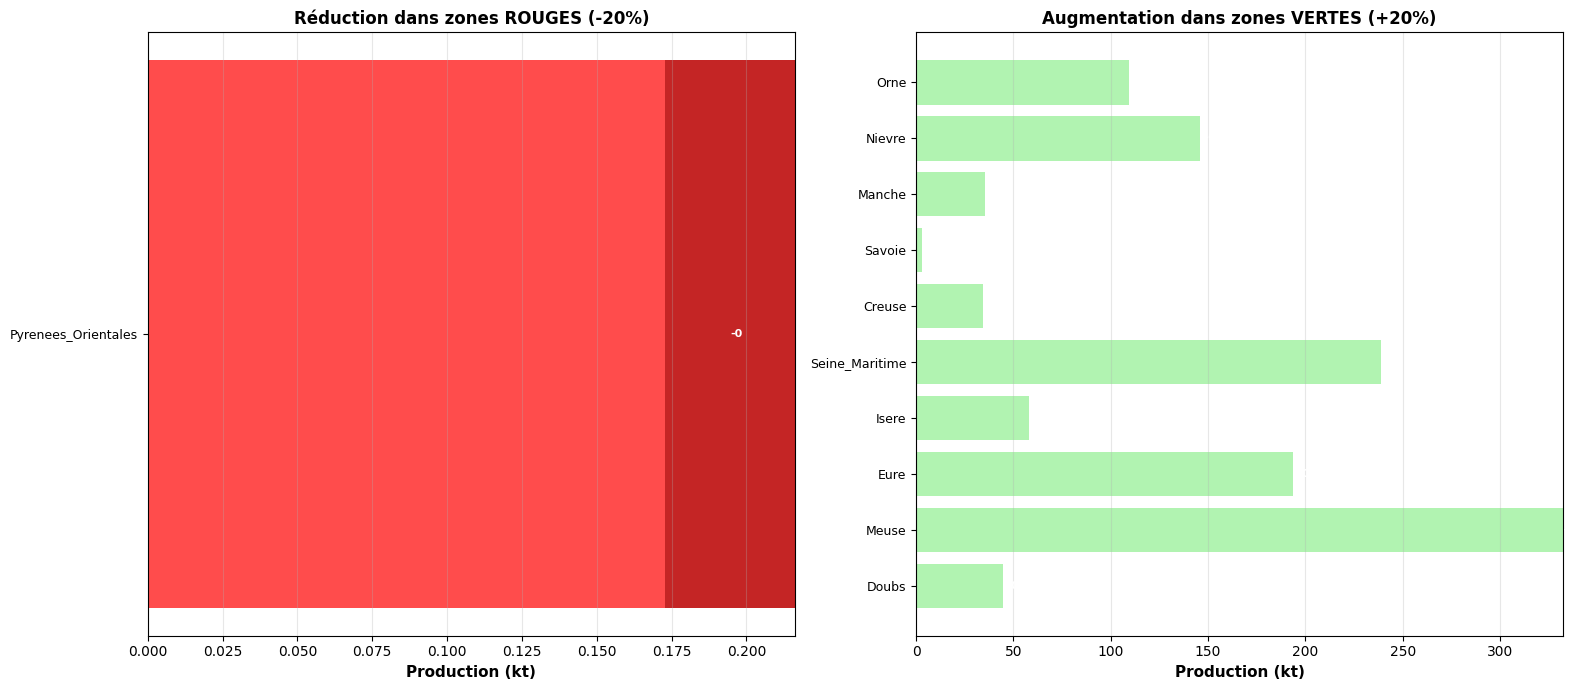

In [35]:
# Visualisation de la réallocation
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Zones à réduire
top10_reduce = zones_a_reduire.head(10)
axes[0].barh(range(len(top10_reduce)), top10_reduce['production_mean']/1000, color='red', alpha=0.7)
for i, (idx, val) in enumerate(zip(top10_reduce.index, top10_reduce['production_mean']/1000)):
    reduction = val * reduction_pct
    axes[0].barh(i, -reduction, color='darkred', alpha=0.5, left=val)
    axes[0].text(val - reduction/2, i, f'-{reduction:.0f}', va='center', fontsize=8, fontweight='bold', color='white')
axes[0].set_yticks(range(len(top10_reduce)))
axes[0].set_yticklabels(top10_reduce['department'], fontsize=9)
axes[0].set_xlabel('Production (kt)', fontsize=11, fontweight='bold')
axes[0].set_title('Réduction dans zones ROUGES (-20%)', fontsize=12, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(True, alpha=0.3, axis='x')

# Zones à augmenter
top10_increase = zones_a_augmenter.head(10)
axes[1].barh(range(len(top10_increase)), top10_increase['production_mean']/1000, color='lightgreen', alpha=0.7)
for i, (idx, val) in enumerate(zip(top10_increase.index, top10_increase['production_mean']/1000)):
    axes[1].barh(i, allocation_per_dept/1000, color='darkgreen', alpha=0.5, left=val)
    axes[1].text(val + allocation_per_dept/2000, i, f'+{allocation_per_dept/1000:.0f}', va='center', fontsize=8, fontweight='bold', color='white')
axes[1].set_yticks(range(len(top10_increase)))
axes[1].set_yticklabels(top10_increase['department'], fontsize=9)
axes[1].set_xlabel('Production (kt)', fontsize=11, fontweight='bold')
axes[1].set_title('Augmentation dans zones VERTES (+20%)', fontsize=12, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()


In [36]:
# Calcul des bénéfices ESG de la réallocation
yield_rouge = zones_a_reduire['yield_mean'].mean()
yield_vert = zones_a_augmenter['yield_mean'].mean()
volatility_rouge = zones_a_reduire['yield_volatility'].mean()
volatility_vert = zones_a_augmenter['yield_volatility'].mean()
days_dry_rouge = zones_a_reduire['days_dry_mean'].mean()
days_dry_vert = zones_a_augmenter['days_dry_mean'].mean()
temp_rouge = zones_a_reduire['temp_mean'].mean()
temp_vert = zones_a_augmenter['temp_mean'].mean()
days_hot_rouge = zones_a_reduire['days_very_hot_mean'].mean()
days_hot_vert = zones_a_augmenter['days_very_hot_mean'].mean()

# Production supplémentaire grâce au meilleur yield
production_supplementaire = production_reduire * (yield_vert / yield_rouge - 1)

print("=== BÉNÉFICES ESG DE LA RÉALLOCATION ===\n")

print("📊 Performance agricole:")
print(f"   Yield moyen zones rouges: {yield_rouge:.2f} t/ha")
print(f"   Yield moyen zones vertes: {yield_vert:.2f} t/ha")
print(f"   Gain de yield: +{yield_vert - yield_rouge:.2f} t/ha ({((yield_vert/yield_rouge - 1)*100):.1f}%)\n")

print(f"🌡️  Impact température:")
print(f"   Température moyenne zones rouges: {temp_rouge:.1f}°C")
print(f"   Température moyenne zones vertes: {temp_vert:.1f}°C")
print(f"   Jours très chauds (>25°C) zones rouges: {days_hot_rouge:.0f} jours/an")
print(f"   Jours très chauds (>25°C) zones vertes: {days_hot_vert:.0f} jours/an")
print(f"   Réduction stress thermique: {days_hot_rouge - days_hot_vert:.0f} jours/an\n")

print(f"💧 Impact eau:")
print(f"   Jours secs moyens zones rouges: {days_dry_rouge:.0f} jours/an")
print(f"   Jours secs moyens zones vertes: {days_dry_vert:.0f} jours/an")
print(f"   Réduction besoins irrigation: {days_dry_rouge - days_dry_vert:.0f} jours/an\n")

print(f"📈 Stabilité:")
print(f"   Volatilité yield zones rouges: {volatility_rouge:.2f}")
print(f"   Volatilité yield zones vertes: {volatility_vert:.2f}")
print(f"   Amélioration stabilité: {volatility_rouge - volatility_vert:.2f} ({((1 - volatility_vert/volatility_rouge)*100):.1f}%)\n")

print(f"💰 Production:")
print(f"   Production réallouée: {production_reduire/1000:.1f} kt")
print(f"   Production supplémentaire (meilleur yield): +{production_supplementaire/1000:.1f} kt")
print(f"   Bilan net: +{production_supplementaire/1000:.1f} kt\n")

print("🌍 Impact ESG total:")
print(f"   ✅ Réduction eau: {production_reduire/1000:.1f} kt de production dans zones sèches")
print(f"   ✅ Réduction température: {temp_rouge - temp_vert:.1f}°C de moins en moyenne")
print(f"   ✅ Réduction CO2: Moins de transport d'urgence, moins de pertes")
print(f"   ✅ Stabilité supply chain: Volatilité réduite de {((1 - volatility_vert/volatility_rouge)*100):.1f}%")


=== BÉNÉFICES ESG DE LA RÉALLOCATION ===

📊 Performance agricole:
   Yield moyen zones rouges: 3.12 t/ha
   Yield moyen zones vertes: 5.74 t/ha
   Gain de yield: +2.62 t/ha (84.0%)

🌡️  Impact température:
   Température moyenne zones rouges: 12.8°C
   Température moyenne zones vertes: 9.9°C
   Jours très chauds (>25°C) zones rouges: 8 jours/an
   Jours très chauds (>25°C) zones vertes: 3 jours/an
   Réduction stress thermique: 6 jours/an

💧 Impact eau:
   Jours secs moyens zones rouges: 319 jours/an
   Jours secs moyens zones vertes: 241 jours/an
   Réduction besoins irrigation: 78 jours/an

📈 Stabilité:
   Volatilité yield zones rouges: 0.55
   Volatilité yield zones vertes: 0.21
   Amélioration stabilité: 0.34 (61.2%)

💰 Production:
   Production réallouée: 0.0 kt
   Production supplémentaire (meilleur yield): +0.0 kt
   Bilan net: +0.0 kt

🌍 Impact ESG total:
   ✅ Réduction eau: 0.0 kt de production dans zones sèches
   ✅ Réduction température: 2.9°C de moins en moyenne
   ✅ Réduct

### Programme de fertilisation durable pour les zones rouges


In [37]:
# Identification des zones rouges qui restent nécessaires (pas toutes peuvent être réduites)
# Certaines zones rouges ont une production trop importante pour être complètement abandonnées
zones_rouges_necessaires = zones_rouges[
    zones_rouges['production_mean'] > zones_rouges['production_mean'].quantile(0.75)
].sort_values('days_dry_mean', ascending=False).head(10)

print("=== PROGRAMME DE FERTILISATION DURABLE ===\n")
print("Pour les zones ROUGES qui restent nécessaires (production stratégique):")
print(f"   Nombre de départements: {len(zones_rouges_necessaires)}\n")

print("Recommandations par département:")
for idx, row in zones_rouges_necessaires.iterrows():
    print(f"\n📍 {row['department']}:")
    print(f"   • Stress hydrique: {row['days_dry_mean']:.0f} jours secs/an")
    print(f"   • Stress thermique: {row['days_very_hot_mean']:.0f} jours très chauds/an (>25°C)")
    print(f"   • Température moyenne: {row['temp_mean']:.1f}°C")
    print(f"   • Yield actuel: {row['yield_mean']:.2f} t/ha")
    print(f"   • Volatilité: {row['yield_volatility']:.2f}")
    print(f"   • Recommandations:")
    print(f"     - Slow-release fertilizers (réduction lessivage)")
    print(f"     - Bio-fertilisants (amélioration sol)")
    print(f"     - Nitrates optimisés (timing irrigation)")
    print(f"     - Pratiques agricoles résilientes (couverture sol, ombrage)")
    print(f"     - Variétés résistantes à la chaleur")

print("\n💡 L'IA + le climat permettent de cibler les bons agriculteurs")
print("   pour déployer une politique durable et réduire l'impact ESG")


=== PROGRAMME DE FERTILISATION DURABLE ===

Pour les zones ROUGES qui restent nécessaires (production stratégique):
   Nombre de départements: 1

Recommandations par département:

📍 Lot_et_Garonne:
   • Stress hydrique: 303 jours secs/an
   • Stress thermique: 29 jours très chauds/an (>25°C)
   • Température moyenne: 13.6°C
   • Yield actuel: 5.18 t/ha
   • Volatilité: 0.51
   • Recommandations:
     - Slow-release fertilizers (réduction lessivage)
     - Bio-fertilisants (amélioration sol)
     - Nitrates optimisés (timing irrigation)
     - Pratiques agricoles résilientes (couverture sol, ombrage)
     - Variétés résistantes à la chaleur

💡 L'IA + le climat permettent de cibler les bons agriculteurs
   pour déployer une politique durable et réduire l'impact ESG


## Résumé de la solution Yield Optimization


In [38]:
print("=== RÉSUMÉ DE LA SOLUTION YIELD OPTIMIZATION ===\n")

print("🎯 PROBLÈME:")
print("   • Rendement instable → sécheresses, vagues de chaleur")
print("   • Impact ESG: plus d'irrigation, pertes, transport d'urgence\n")

print("✅ SOLUTION EN 4 ÉTAPES:\n")

print("1️⃣  Analyse descriptive:")
print(f"   • Identifié {len(high_risk_depts)} départements à risque climatique")
print("   • Critères: peu de précipitations + variabilité + faible yield + grande surface\n")

print("2️⃣  Modèle prédictif:")
print(f"   • R² = {r2_test:.3f} → {r2_test*100:.1f}% de variance expliquée par le climat")
print(f"   • Variables clés: {', '.join(feature_importance.head(3)['feature'].tolist())}\n")

print("3️⃣  Classification résilience:")
print(f"   • {zone_counts.get('Vert', 0)} départements VERTES (résilients)")
print(f"   • {zone_counts.get('Orange', 0)} départements ORANGES (moyens)")
print(f"   • {zone_counts.get('Rouge', 0)} départements ROUGES (à risque)\n")

print("4️⃣  Optimisation achats:")
print(f"   • Réduction -20% dans zones rouges: {production_reduire/1000:.1f} kt")
print(f"   • Augmentation +20% dans zones vertes")
print(f"   • Programme fertilisation durable pour zones rouges restantes\n")

print("🌍 IMPACT ESG:")
print(f"   • Réduction eau: {production_reduire/1000:.1f} kt dans zones sèches")
print(f"   • Gain yield: +{yield_vert - yield_rouge:.2f} t/ha ({((yield_vert/yield_rouge - 1)*100):.1f}%)")
print(f"   • Stabilité: Volatilité réduite de {((1 - volatility_vert/volatility_rouge)*100):.1f}%")
print(f"   • Production supplémentaire: +{production_supplementaire/1000:.1f} kt")


=== RÉSUMÉ DE LA SOLUTION YIELD OPTIMIZATION ===

🎯 PROBLÈME:
   • Rendement instable → sécheresses, vagues de chaleur
   • Impact ESG: plus d'irrigation, pertes, transport d'urgence

✅ SOLUTION EN 4 ÉTAPES:

1️⃣  Analyse descriptive:
   • Identifié 34 départements à risque climatique
   • Critères: peu de précipitations + variabilité + faible yield + grande surface

2️⃣  Modèle prédictif:
   • R² = 0.462 → 46.2% de variance expliquée par le climat
   • Variables clés: precip_min, temp_max, temp_mean

3️⃣  Classification résilience:
   • 62 départements VERTES (résilients)
   • 24 départements ORANGES (moyens)
   • 3 départements ROUGES (à risque)

4️⃣  Optimisation achats:
   • Réduction -20% dans zones rouges: 0.0 kt
   • Augmentation +20% dans zones vertes
   • Programme fertilisation durable pour zones rouges restantes

🌍 IMPACT ESG:
   • Réduction eau: 0.0 kt dans zones sèches
   • Gain yield: +2.62 t/ha (84.0%)
   • Stabilité: Volatilité réduite de 61.2%
   • Production supplémen